## Linearna regresija u biblioteci PyTorch

U ovoj svesci biće prikazan trening modela linearne regresije na Boston Housing skupu podataka, korišćenjem gradijentnog spusta uz pomoć biblioteke PyTorch.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import datasets 
from sklearn import preprocessing

#### Učitavanje podataka

In [2]:
data_url = "https://lib.stat.cmu.edu/datasets/boston"
column_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS",
    "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"
]

raw_data = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None).values
raw_data = np.hstack([raw_data[::2], raw_data[1::2]])[:, :14]
raw_data = pd.DataFrame(raw_data, columns=column_names)
raw_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


#### Podela na skup za trening i validaciju i standardizacija podataka

In [3]:
X = raw_data.drop(columns=["MEDV"])
y = raw_data["MEDV"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Definisanje torch dataseta-a i dataloadera-a

In [5]:
BATCH_SIZE = 32

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # nije neophodno ukoliko je CPU

# prebacivanje podataka u PyTorch tenzore
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Pakovanje podataka u Dataset
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Kreiranje DataLoader-a
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


#### Definisanje modela

In [6]:
# definicija klase modela
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return self.linear(x)

# kreiranje modela i prebacivanje na odgovarajući uređaj
input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim).to(DEVICE)

#### Optimizacija modela

In [7]:
learning_rate = 0.01          # stopa ucenja
NUM_EPOCHS = 20   # broj epoha

# definisanje algoritma optimizacije
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# nekada se neki slojevi modela ponasaju drugačije tokom treniranja i testiranja
# zato prebacujemo model u režim treniranja
model.train()

for epoch in range(NUM_EPOCHS):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Računanje predviđanja modela
        y_pred = model(x_batch)

        # Izračunavanje greške
        loss = (y_pred - y_batch.view(-1, 1)).pow(2).mean()
        
        # Resetovanje gradijenata
        optimizer.zero_grad()

        # Računanje gradijenata propagacijom unazad
        loss.backward()

        # Ažuriranje težina
        optimizer.step()


⚠️ Linija `loss = (y_pred - y_batch.view(-1, 1)).pow(2).mean()` je mesto gde se jako često pravi greška! ⚠️

Pogledajmo oblike ovih tenzora:

In [8]:
print('y_pred:', y_pred.shape)
print('y_batch:', y_batch.shape)

y_pred: torch.Size([20, 1])
y_batch: torch.Size([20])


Ukoliko bismo izostavili `.view(-1, 1)` zbog pravila broadcasting-a, pogrešno bismo izračunali srednjekvadratnu grešku.

In [9]:
a = torch.tensor([1, 2, 3], dtype=torch.float32)
b = torch.tensor([[1], [2], [3]], dtype=torch.float32)
print('a.shape:', a.shape)
print('b.shape:', b.shape)
print('Pogresno:', (b - a).pow(2).mean())
print('Ispravno:', (b - a.view(-1, 1)).pow(2).mean())

print('---')
print('Razlog greške:')
print('b - a:', b - a)

a.shape: torch.Size([3])
b.shape: torch.Size([3, 1])
Pogresno: tensor(1.3333)
Ispravno: tensor(0.)
---
Razlog greške:
b - a: tensor([[ 0., -1., -2.],
        [ 1.,  0., -1.],
        [ 2.,  1.,  0.]])


#### Validacija modela

In [10]:
model.eval()  # prebacivanje modela u režim testiranja

predictions = []
with torch.no_grad():  # isključivanje izračunavanja gradijenata
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Računanje predviđanja modela
        y_pred = model(x_batch)
        predictions.append(y_pred.cpu())

predictions = torch.cat(predictions, dim=0)
print('predictions:', predictions.shape)
print('y_test:', y_test.shape)

print('MSE: ', (predictions - y_test.view(-1, 1)).pow(2).mean())
print('MAE: ', (predictions - y_test.view(-1, 1)).abs().mean())

predictions: torch.Size([102, 1])
y_test: torch.Size([102])
MSE:  tensor(428.2720)
MAE:  tensor(19.8940)


#### Vizuelizacija procesa treninga

Prilikom treninga, nakon svakog koraka gradijentnog spusta (nakon poziva `optimizer.step()`) parametri modela koji se trenira bivaju ažurirani. Očekujemo da smo ovim promenama model poboljšali, ali to ne mora biti slučaj, može doći do preprilagođavanja ili zbog prevelike stope učenja model može da stagnira (ili čak da se pogoršava!). Iz tog razloga korisno je u toku treninga prikazati promenu funkcije greške, kao i drugih metrika od interesa. 

In [13]:

metrics = {
    'mse': [],
    'val_mse': [],
    'mae': [],
    'val_mae': [],
    'step': [],
    'val_step': [],
}

model = LinearRegressionModel(input_dim).to(DEVICE)  # ponovo inicijalizujemo model

learning_rate = 0.01        # stopa ucenja
NUM_EPOCHS = 20   # broj epoha

# definisanje algoritma optimizacije
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# nekada se neki slojevi modela ponasaju drugačije tokom treniranja i testiranja
# zato prebacujemo model u režim treniranja
training_step = 0
for epoch in range(NUM_EPOCHS):
    model.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Računanje predviđanja modela
        y_pred = model(x_batch)

        # Izračunavanje greške
        loss = (y_pred - y_batch.view(-1, 1)).pow(2).mean()
        
        # Resetovanje gradijenata
        optimizer.zero_grad()

        # Računanje gradijenata propagacijom unazad
        loss.backward()

        # Ažuriranje težina
        optimizer.step()

        # čuvanje metrika
        metrics['mse'].append(loss.item())
        metrics['mae'].append((y_pred - y_batch.view(-1, 1)).abs().mean().item())
        metrics['step'].append(training_step)
        training_step += 1
    
    # testiranje modela
    model.eval()
    predictions = []
    with torch.no_grad():  # isključivanje izračunavanja gradijenata
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Računanje predviđanja modela
            y_pred = model(x_batch)
            predictions.append(y_pred.cpu())
    predictions = torch.cat(predictions, dim=0)
    # čuvanje metrika
    metrics['val_mse'].append((predictions - y_test.view(-1, 1)).pow(2).mean().item())
    metrics['val_mae'].append((predictions - y_test.view(-1, 1)).abs().mean().item())
    metrics['val_step'].append(training_step)


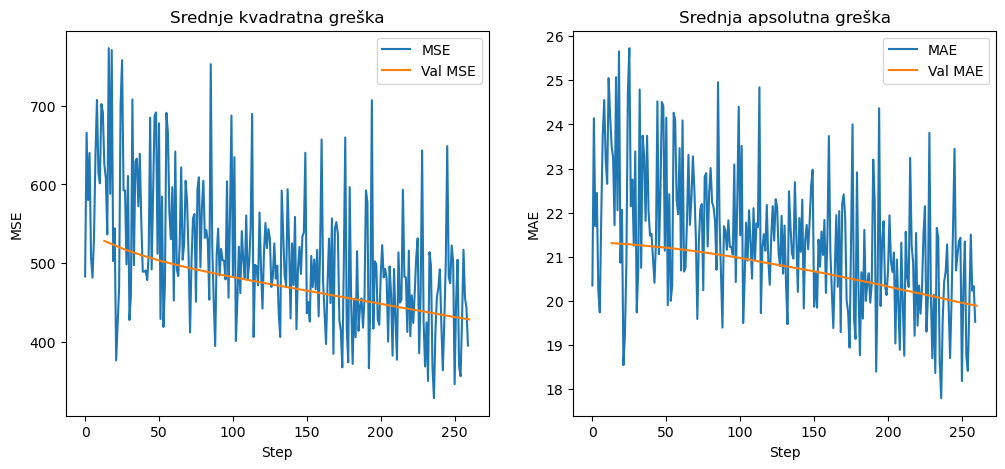

In [14]:
# vizualizacija metrika
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(metrics['step'], metrics['mse'], label='MSE')
plt.plot(metrics['val_step'], metrics['val_mse'], label='Val MSE')
plt.xlabel('Step')
plt.ylabel('MSE')
plt.title('Srednje kvadratna greška')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['step'], metrics['mae'], label='MAE')
plt.plot(metrics['val_step'], metrics['val_mae'], label='Val MAE')
plt.xlabel('Step')
plt.ylabel('MAE')
plt.title('Srednja apsolutna greška')
plt.legend()

plt.show()

Možemo videti trend opadanja, koji je sporiji nego što bismo možda voleli, tako da ima smisla razmatrati veću stopu učenja, kao i možda nešto veći broj epoha treninga. Pokušajte da promenom ova dva parametra dođete do srednjekvadratne greške manje od 25.

⚠️ Ovaj proces pronalaska optimalnih hiperparametara je deo selekcije modela. Kako bi se on ispravno evaluirao bilo bi **neophodno** da odvojimo skup podataka na skup za trening, validaciju i test modela. **Celokupan proces izbora hiperparametara** trebalo bi raditi na skupovima za trening i validaciju, dok bi za konačnu evaluaciju najboljeg modela koristili test skup ⚠️